# README
This notebook is shared FOR REFERENCE ONLY, as supporting material for the paper "Ubiquity of human-induced changes in climate variability", Rodger et al, Earth System Dynamics, 2021.
(https://doi.org/10.5194/esd-2021-50)

The notebook calculates the wavelet power spectrum of the Niño3.4 index, as part of Figure 3 in the main text.

The calculations follow Torrence, C., and G. P. Compo, 1998: A practical guide to wavelet analysis. Bull. Amer. Meteor. Soc., 79, 61–78.

Wavelet analysis code translated to Python and provided here courtesy of:

Evgeniya Predybaylo
predybaylo[DOT]evgenia[AT]gmail[DOT]com
Earth Sciences and Engineering Program
King Abdullah University of Science and Technology
Kingdom of Saudi Arabia

For questions regarding this notebook, please email the author, Karl Stein at:
iccp[DOT]stein[AT]gmail[DOT]com

In [1]:
from dask.distributed import Client
client = Client(scheduler_file='/proj/kstein/MPI/scheduler.json')

In [2]:
client

Client Scheduler: tcp://203.247.189.225:46757 Dashboard: http://203.247.189.225:8742/status,Cluster Workers: 5 Cores: 180 Memory: 139.70 GiB


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import glob
import sys
sys.path.append('/proj/kstein/Testbed/wavelets')
from waveletFunctions import wavelet, wave_signif
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
def process_coords(ds, concat_dim='time', drop=True, extra_coord_vars=['time_bound']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = [v for v in ds.data_vars if concat_dim not in ds[v].dims]
    for ecv in extra_coord_vars:
        if ecv in ds:
            coord_vars += extra_coord_vars
    if drop:
        return ds.drop(coord_vars)
    else:
        return ds.set_coords(coord_vars)

In [5]:
from cartopy.util import add_cyclic_point
def xr_add_cyclic_point(da,tname=None):
    """
    Inputs
    da: xr.DataArray with dimensions (tname,lat,lon)
    
    """
    
    # Use add_cyclic_point to interpolate input data
    lon_idx = da.dims.index('lon')
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon, axis=lon_idx)
    # Generate output DataArray with new data but same structure as input
    if tname!=None :
        outp_da = xr.DataArray(data=wrap_data,
                               coords = { tname: da[tname], 'lat': da.lat, 'lon': wrap_lon},
                               dims=da.dims,
                               attrs=da.attrs)
    else :
        outp_da = xr.DataArray(data=wrap_data,
                               coords = {'lat': da.lat, 'lon': wrap_lon},
                               dims=da.dims,
                               attrs=da.attrs)
    return outp_da

In [6]:
def load_CESM_lens_ds(ensemble_names,domain,freq,var):
    
    import glob
    import xarray as xr
   
    ens_dir = '/proj/jedwards/archive/'
    
    ens_files = []
    for ens_name in ensemble_names:
        datadir = ens_dir  + ens_name + '/' + domain + '/proc/tseries/' + freq + '/'
        ncfiles = glob.glob(datadir + ens_name + '.*.' + var + '.*.nc')

        files = [ncfile for ncfile in sorted(ncfiles)]
        ens_files.append(files)

    ds = xr.open_mfdataset(ens_files,
                                    combine='nested',
                                    concat_dim=[[*ens_numbers],'time'],
                                    preprocess=process_coords,
                                    parallel='True',
                                    decode_cf = False,
                                    decode_times = False)
    ds = ds.rename({'concat_dim' : 'ensemble'})
    return ds

In [7]:
proj_dir = '/proj/kstein/CESM2_LE/Presentation_paper/'
ens_dir = '/proj/jedwards/archive/'

ens_numbers = []
hist_ens_names = []
ssp_ens_names = []

# initial macro ensemble members
ic_times = range(1001,1202,20)
members = range(1,11)

macro_members = [str(ic_times[ind]) + '.' + str(members[ind]).zfill(3) for ind in range(10)]
ens_numbers.extend(macro_members)

hist_macro_names =['b.e21.BHISTcmip6.f09_g17.LE2-' + n for n in macro_members]
ssp_macro_names =['b.e21.BSSP370cmip6.f09_g17.LE2-' + n for n in macro_members]

hist_ens_names.extend(hist_macro_names)
ssp_ens_names.extend(ssp_macro_names)

# micro ensembles
ic_times = (1231,1251,1281,1301)

members = range(1,11)

cmip6_micro_members = [str(ict) + '.' + str(m).zfill(3) for ict in ic_times for m in members]
ens_numbers.extend(cmip6_micro_members)

hist_cmip6_ens_names = ['b.e21.BHISTcmip6.f09_g17.LE2-' + n for n in cmip6_micro_members]
ssp_cmip6_ens_names = ['b.e21.BSSP370cmip6.f09_g17.LE2-' + n for n in cmip6_micro_members]

hist_ens_names.extend(hist_cmip6_ens_names)
ssp_ens_names.extend(ssp_cmip6_ens_names)

members = range(11,21)
smbb_micro_members = [str(ict) + '.' + str(m).zfill(3) for ict in ic_times for m in members]
ens_numbers.extend(smbb_micro_members)

hist_smbb_ens_names = ['b.e21.BHISTsmbb.f09_g17.LE2-' + n for n in smbb_micro_members]
ssp_smbb_ens_names = ['b.e21.BSSP370smbb.f09_g17.LE2-' + n for n in smbb_micro_members]

hist_ens_names.extend(hist_smbb_ens_names)
ssp_ens_names.extend(ssp_smbb_ens_names)

# MOAR members

ic_times = range(1011,1201,20)
members = range(1,11)

moar_members = [str(ic_times[ind]) + '.' + str(members[ind]).zfill(3) for ind in range(10)]
ens_numbers.extend(moar_members)

hist_moar_names =['b.e21.BHISTsmbb.f09_g17.LE2-' + n for n in moar_members]
ssp_moar_names =['b.e21.BSSP370smbb.f09_g17.LE2-' + n for n in moar_members]

hist_ens_names.extend(hist_moar_names)
ssp_ens_names.extend(ssp_moar_names)

hist_ens_names = sorted(hist_ens_names)
ssp_ens_names = sorted(ssp_ens_names)

In [8]:
domain = 'atm'
freq = 'month_1'
var = 'TS'

hist_ts_ds = load_CESM_lens_ds(hist_ens_names,domain,freq,var)
hist_ts_ds['time'] = xr.cftime_range(start='1850-01-01',
                                       end = '2014-12-31',
                                       freq = 'M',
                                       calendar = 'noleap')
hist_ts_da = hist_ts_ds[var] - 273.15

ssp_ts_ds = load_CESM_lens_ds(ssp_ens_names,domain,freq,var)
ssp_ts_ds['time'] = xr.cftime_range(start='2015-01-01',
                                       end = '2100-12-31',
                                       freq = 'M',
                                       calendar = 'noleap')
ssp_ts_da = ssp_ts_ds[var] - 273.15

ts_da = xr.concat([hist_ts_da,ssp_ts_da],dim = 'time')
ts_da

,Array,Chunk
Bytes,62.05 GiB,25.31 MiB
Shape,"(100, 3012, 192, 288)","(1, 120, 192, 288)"
Count,18200 Tasks,2600 Chunks
Type,float32,numpy.ndarray


In [9]:
domain = 'atm'
freq = 'month_1'
var = 'PRECT'

hist_p_ds = load_CESM_lens_ds(hist_ens_names,domain,freq,var)
hist_p_ds['time'] = xr.cftime_range(start='1850-01-01',
                                       end = '2014-12-31',
                                       freq = 'M',
                                       calendar = 'noleap')
hist_p_da = hist_p_ds[var]

ssp_p_ds = load_CESM_lens_ds(ssp_ens_names,domain,freq,var)
ssp_p_ds['time'] = xr.cftime_range(start='2015-01-01',
                                       end = '2100-12-31',
                                       freq = 'M',
                                       calendar = 'noleap')
ssp_p_da = ssp_p_ds[var]

unit_con = 60*60*24*1000
hist_p_da = hist_p_da * unit_con
ssp_p_da = ssp_p_da * unit_con

p_da = xr.concat([hist_p_da,ssp_p_da],dim = 'time')
p_da

,Array,Chunk
Bytes,124.09 GiB,50.62 MiB
Shape,"(100, 3012, 192, 288)","(1, 120, 192, 288)"
Count,18200 Tasks,2600 Chunks
Type,float64,numpy.ndarray


In [10]:
ts_nino_da = ts_da.sel(time=slice('1960','2100'))
ts_nino_da = ts_nino_da.sel(lat=slice(-5,5),lon=slice(190,240))
ts_nino_da = ts_nino_da.mean(dim=['lat','lon'])
ts_nino_da = ts_nino_da.compute()

In [11]:
p_nino_da = p_da.sel(time=slice('1960','2100'))
p_nino_da = p_nino_da.sel(lat=slice(-5,5),lon=slice(190,240))
p_nino_da = p_nino_da.mean(dim=['lat','lon'])
p_nino_da = p_nino_da.compute()

In [12]:
ts_anom_da = ts_nino_da - ts_nino_da.mean(dim='ensemble')
ts_anom_da = ts_anom_da.compute()

In [13]:
p_anom_da = p_nino_da - p_nino_da.mean(dim='ensemble')
p_anom_da = p_anom_da.compute()

In [14]:
ts_nino_yrmean_da = ts_nino_da.resample(time='1Y').mean()
ts_nino_yrmean_da = ts_nino_yrmean_da.resample(time='1M').interpolate('linear')
ts_detrend_da = ts_nino_da - ts_nino_yrmean_da
ts_detrend_da = ts_detrend_da.compute()
ts_detrend_da = ts_detrend_da.sel(time=slice('1961','2100'))

In [15]:
p_nino_yrmean_da = p_nino_da.resample(time='1Y').mean()
p_nino_yrmean_da = p_nino_yrmean_da.resample(time='1M').interpolate('linear')
p_detrend_da = p_nino_da - p_nino_yrmean_da
p_detrend_da = p_detrend_da.compute()
p_detrend_da = p_detrend_da.sel(time=slice('1961','2100'))

### Calculate wavelet spectrum of single time series to determine size of the output array

In [22]:
ts = ts_detrend_da.isel(ensemble=0).values

ts = ts - np.mean(ts)
variance = np.std(ts, ddof=1) ** 2

n = len(ts)
dt = 1/12
time = np.arange(len(ts)) * dt + 1960.0  # construct time array
xlim = ([1960, 2100])  # plotting range
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.125  # this will do 4 sub-octaves per octave
s0 = 6 * dt  # this says start at a scale of 6 months
j1 = 5 / dj  # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
print("lag1 = ", lag1)
mother = 'MORLET'

lag1 =  0.72


In [23]:
wave, period, scale, coi = wavelet(ts, dt, pad, dj, s0, j1, mother)
power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
global_ws = (np.sum(power, axis=1) / n)  # time-average over all times

In [57]:
P,T = np.shape(wave)
wave_ens = np.zeros((100,P,T),dtype = 'complex_')
ens_std = np.zeros((100,))

for i in range(100):
    ts = ts_detrend_da.isel(ensemble=i).values
    ts = ts - np.mean(ts)
    ens_std[i] = np.std(ts, ddof=1) 
    wave_i, period, scale, coi = wavelet(ts, dt, pad, dj, s0, j1, mother)
    wave_ens[i,:,:] = wave_i

ts_variance = np.mean(ens_std)**2 

power_ens = (np.abs(wave_ens)) ** 2  # compute wavelet power spectrum
ts_power = np.mean(power_ens,axis=0)/ts_variance
#global_ws = (np.sum(power, axis=1) / n)  # time-average over all times

# signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,
#     lag1=lag1, mother=mother)
# sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand signif --> (J+1)x(N) array
# sig95 = power / sig95  # where ratio > 1, power is significant

wave_ens = np.zeros((100,P,T),dtype = 'complex_')
ens_std = np.zeros((100,))

for i in range(100):
    ts = p_detrend_da.isel(ensemble=i).values
    ts = ts - np.mean(ts)
    ens_std[i] = np.std(ts, ddof=1) 
    wave_i, period, scale, coi = wavelet(ts, dt, pad, dj, s0, j1, mother)
    wave_ens[i,:,:] = wave_i
    
coi = coi[:-1]

p_variance = np.mean(ens_std)**2 

power_ens = (np.abs(wave_ens)) ** 2  # compute wavelet power spectrum
p_power = np.mean(power_ens,axis=0)/p_variance

In [59]:
wave_ds = xr.Dataset(
         data_vars=dict(
             ts_power=(["time", "period"], ts_power.T),
             p_power=(["time", "period"], p_power.T),
             coi=(["time"], coi)
         ),
         coords=dict(
             time=time,
             period=period,
         ),
         attrs=dict(description="CESM2 LENS Niño3.4 TS,PRECT wavelets."),
     )
wave_ds

<xarray.Dataset>
Dimensions:   (period: 41, time: 1680)
Coordinates:
  * time      (time) float64 1.96e+03 1.96e+03 1.96e+03 ... 2.1e+03 2.1e+03
  * period    (period) float64 0.5165 0.5633 0.6143 0.6698 ... 13.9 15.16 16.53
Data variables:
    ts_power  (time, period) float64 0.2664 0.3577 0.4465 ... 0.08067 0.06903
    p_power   (time, period) float64 0.2772 0.3547 0.4608 ... 0.04977 0.04376
    coi       (time) float64 6.087e-07 0.0 0.06087 ... 0.1217 0.06087 6.087e-07
Attributes:
    description:  CESM2 LENS Niño3.4 TS,PRECT wavelets.

In [63]:
out_dir = proj_dir + 'output/Nino34/'
nc_file = 'CESM2_LENS_Nino34_TS_PRECT_wavelets.nc'

wave_ds.to_netcdf(out_dir + nc_file, mode = 'w', format='NETCDF4_CLASSIC')

In [8]:
proj_dir = '/proj/kstein/CESM2_LE/Presentation_paper/'
out_dir = proj_dir + 'output/Nino34/'
nc_file = 'CESM2_LENS_Nino34_TS_PRECT_wavelets.nc'

wave_ds = xr.open_dataset(out_dir + nc_file)
wave_ds

<xarray.Dataset>
Dimensions:   (period: 41, time: 1680)
Coordinates:
  * time      (time) float64 1.96e+03 1.96e+03 1.96e+03 ... 2.1e+03 2.1e+03
  * period    (period) float64 0.5165 0.5633 0.6143 0.6698 ... 13.9 15.16 16.53
Data variables:
    ts_power  (time, period) float64 ...
    p_power   (time, period) float64 ...
    coi       (time) float64 ...
Attributes:
    description:  CESM2 LENS Niño3.4 TS,PRECT wavelets.

/home/kstein/miniconda3/envs/edge/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  from ipykernel import kernelapp as app
/home/kstein/miniconda3/envs/edge/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The 'subsy' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  from ipykernel import kernelapp as app


Text(0.5, 0, 'Time (year)')

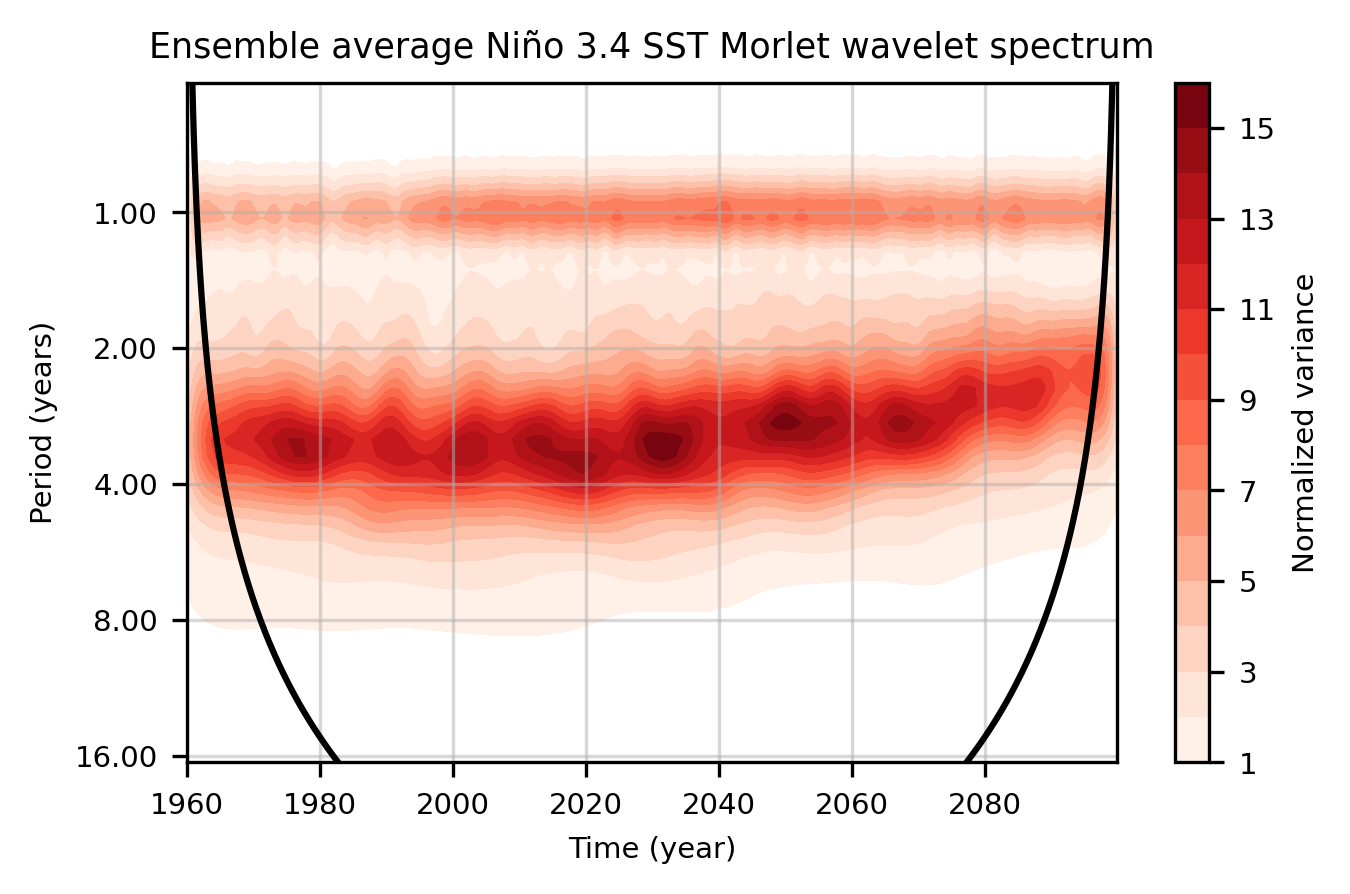

In [9]:
time = wave_ds.time.values
period = wave_ds.period.values
coi = wave_ds.coi.values
ts_power = wave_ds.ts_power.values

plt.rcParams.update({'font.size': 7})
fig1 = plt.figure(num=1,figsize=(5, 3), dpi=300,
                 #constrained_layout=True,
                 facecolor='w', edgecolor='k')
levs = np.arange(1,17)
ax1 = plt.subplot(111)
cl = ax1.contourf(time, period, ts_power.T, 
                  levels = levs, cmap = plt.cm.Reds)
ax1.plot(time, coi, 'k')
ax1.set_yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax1.invert_yaxis()
ax1.grid(True,alpha=.5)
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
cb = plt.colorbar(cl,ax=ax1)
cb.ax.set_ylabel('Normalized variance', rotation=90)
ax1.set_title('Ensemble average Niño 3.4 SST Morlet wavelet spectrum')
ax1.set_ylabel('Period (years)')
ax1.set_xlabel('Time (year)')

/home/kstein/miniconda3/envs/edge/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/home/kstein/miniconda3/envs/edge/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The 'subsy' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 0, 'Time (year)')

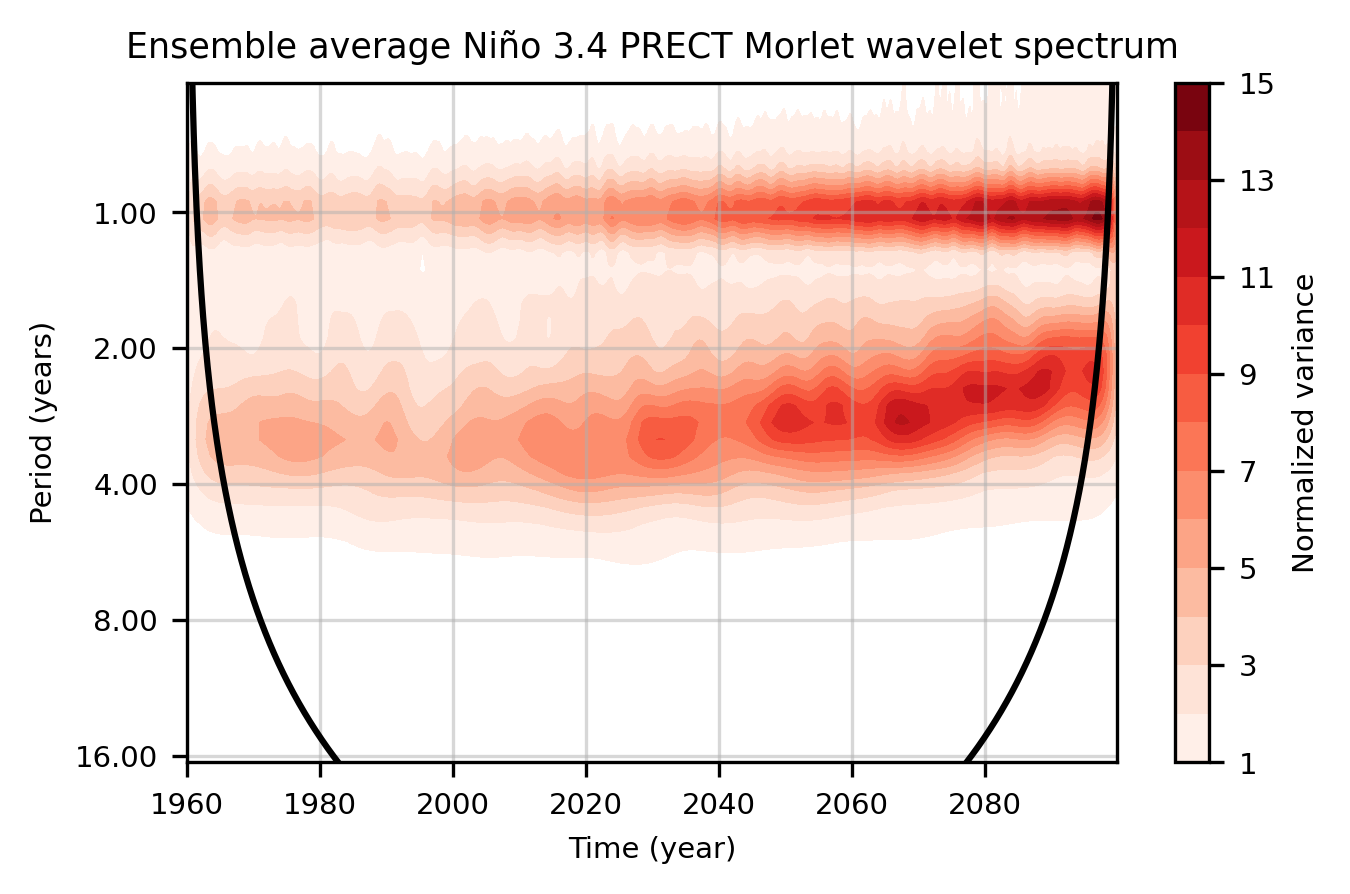

In [33]:
plt.rcParams.update({'font.size': 7})
fig1 = plt.figure(num=1,figsize=(5, 3), dpi=300,
                 #constrained_layout=True,
                 facecolor='w', edgecolor='k')
levs = np.arange(1,16)
ax1 = plt.subplot(111)
cl = ax1.contourf(time, period, p_power, 
                  levels = levs, cmap = plt.cm.Reds)
ax1.plot(time, coi[:-1], 'k')
ax1.set_yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax1.invert_yaxis()
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
cb = plt.colorbar(cl,ax=ax1)
ax1.grid(True,alpha=.5)
cb.ax.set_ylabel('Normalized variance',rotation=90)
ax1.set_title('Ensemble average Niño 3.4 PRECT Morlet wavelet spectrum')
ax1.set_ylabel('Period (years)')
ax1.set_xlabel('Time (year)')